In [145]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from IPython.display import Image
import os

<h3><center>Omówienie funkcji wykonujące pomniejsze czynności potrzebne do działania algorytmu</h3>
<span style="font-size:15px">
* <b>compute distance</b> - podaje odległość pomiędzy dwoma wybranymi miastami (punktami)
* <b>route_length</b> - oblicza sumaryczną długość trasy obranej przez 'komiwojażera'
* <b>calculate_fitness</b> - zwraca ujemną długość pokonanej przez 'sprzedawcę' trasy, która jest naszą funkcją celu do optymalizacji
* <b>plot_route</b> - przedstawia obraną trasę pomiędzy miastami (punktami) na wykresie
* <b>get_individual_route</b> - tworzy wektor z kolejnością odwiedzanych miast dla danego osobnika z populacji tzw. genotyp
* <b>initial_population</b> - zwraca populację (posortowną rosnąco względem funkcji celu) w której każdy osobnik ma swoją trasę przejścia pomiędzy miastami
* <b>get_parents</b> - wybiera najlepsze osobniki z populacji (z największą funkcją celu) na rodziców, po których potomstwo odziedziczy geny (kolejność odwiedzania miast)
* <b>cross</b> - fragmenty genów rodziców są ze sobą krzyżowane w celu uzyskania nowego potomka
* <b>mutate</b> - funkcja zwraca zmutowany (zmieniony) w niektórych miejsach gen danego osobnika
* <b>replace_population</b> - dodaje do populacji nowe potomne osobniki i sortuje ją rosnąco względem funkcji celu <br>
<b>Uwaga</b> ! W powyższym wyjaśnieniu przez osobnika z genotypem rozumiem wektor z kolejnością odwiedzania miast, a poprzez populację zbiór osobników.

In [146]:
def compute_distances(cities):
    return np.linalg.norm(cities[:, np.newaxis] - cities, axis = 2)

In [147]:
def route_length(distances, route):
    return np.sum(distances[route, np.roll(route, -1)])

In [148]:
def calculate_fitness(cities):
    distances = compute_distances(cities)
    def fitness(route):
        return -route_length(distances, route)
    return fitness

In [149]:
def plot_route(cities, route, distances, generation, show = False):
    length = route_length(distances, route)
    
    plt.figure(figsize = (12,8))
    plt.scatter(x = cities[:, 0], y = cities[:, 1], s= 1000, zorder=1, color='deeppink')
    for i in range(len(cities)):
        plt.text(cities[i][0], cities[i][1], str(i), horizontalalignment='center', verticalalignment='center', size = 10, c = 'white')
    for i in range(len(route)):
        plt.plot([cities[route[i]][0], cities[route[(i+1)%len(route)]][0]],
                 [cities[route[i]][1], cities[route[(i+1)%len(route)]][1]], 'k', zorder = 0)
    plt.title(f'Generation: {generation}, visting {len(route)} cities in length {length:.2f}', size = 10)
    
    if show:
        plt.show()
        
    plt.savefig(f'{generation}.png')
    plt.close()

In [150]:
def get_individual_route(number_of_cities):
    return np.random.choice(range(number_of_cities), number_of_cities, replace = False)

In [151]:
def initial_population(number_of_cities, population_size, fitness):
    population = sorted([get_individual_route(number_of_cities) for _ in range(population_size)], key = fitness)
    return population

In [152]:
def get_parents(population, number_of_offsprings):
    mothers = population[-2 * number_of_offsprings::2]
    fathers = population[-2 * number_of_offsprings + 1::2]
    return mothers, fathers

In [153]:
def cross(mother, father):
    mother_head = mother[:int(len(mother) * 0.5)].copy()
    mother_tail = mother[int(len(mother) * 0.5):].copy()
    father_tail = father[int(len(father) * 0.5):].copy()
    
    mapping = {father_tail[i] : mother_tail[i] for i in range(len(mother_tail))}
    
    for i in range(len(mother_head)):
        while mother_head[i] in father_tail:
            mother_head[i] = mapping[mother_head[i]]
            
    return np.hstack([mother_head, father_tail])

In [154]:
def mutate(offspring):
    i, j = np.random.choice(range(len(offspring)), 2, replace = False)
    offspring[i], offspring[j] = offspring[j], offspring[i]
    return offspring

In [155]:
def replace_population(population, new_individuals, fitness):
    population += new_individuals
    population.sort(key = fitness)
    return population[-len(population):]

<h3><center>Posczególne kroki ewolucji</h3>
<span style="font-size:15px">Poniższy kod przedstawia pojedyńczy krok w procesie działania algorytmu/ewolucji. Krok ten polega na stworzeniu nowego pokolenia w opraciu o najlepszych rodziców. W procesie rozmnażania mogą brać udział wyżej wymienione funkcje <b>cross</b> i <b>mutate</b> zwiększające róźnordność populacji i wprowadzające czynnik losowości, jednak są one ograniczone przez podane w parametrach algorytmu prawdopodbieństwa ich wystąpienia.

In [156]:
def evolution_step(population, fitness, number_of_offsprings, mutation_rate, cross_rate):
    offsprings = []
    
    for mother, father in zip(*get_parents(population, number_of_offsprings)):
        offspring = cross(mother, father) if np.random.rand() < cross_rate else mother.copy()
        offsprings.append(mutate(offspring) if np.random.rand() < mutation_rate else offspring)
        
    return replace_population(population, offsprings, fitness)

<h3><center>Parametry ewolucyjne do dostosowania oraz główny algorytm</h3>
<span style="font-size:15px">Algorytm posiada parametry, które można dostosowywać chcą osiągnąć jak najlepszy efekt optymalizacji. Po kilkunastu próbach pracy algorytmu wydaje się, że te ustawione poniżej są jednymi z lepszych. Główna funkcja wywołuje pojedynczy krok ewolucji, aż do momentu kiedy optymalna długość trasy 'komiwojażera' nie zmieni się po 50 iteracjach, wtedy przerywa i zwraca wynik.

In [157]:
# Parameters
number_of_cities = 23  # to change
population_size = 100
number_of_offsprings = 30
mutation_rate = 0.075
cross_rate = 0.6

In [158]:
cities_list = np.random.randint(0, 300, size = (number_of_cities, 2))
distances = compute_distances(cities_list)

def evolution(number_of_cities, fitness, population_size, number_of_offsprings, mutation_rate, cross_rate):
    fitness_change = []
    population = initial_population(number_of_cities, population_size, fitness)
    generations_without_improvement = 0
    best_fitness = fitness(population[-1])
    
    while generations_without_improvement < 50:
        population = evolution_step(population, fitness, number_of_offsprings, mutation_rate, cross_rate)
        
        if fitness(population[-1]) > best_fitness:
            best_fitness = fitness(population[-1])
            generations_without_improvement = 0
        else:
            generations_without_improvement += 1
        
        best_individual = population[-1]
        fitness_change.append(fitness(best_individual))
        plot_route(cities_list, route = best_individual, distances = distances, generation = len(fitness_change))
        
    return fitness_change

fitness_change = evolution(number_of_cities, calculate_fitness(cities_list), population_size, number_of_offsprings, mutation_rate, cross_rate)

<h3><center>Wizualizacja odwróconej funkcji odległości oraz procesu powstawania optymalnego rozwiązania</h3>
<span style="font-size:15px">Wizualizacje przedstawiają funkcję celu, pozwalająca kontrolować czy nasz algorytm na pewno dobrze pracuje i dąży ku polepszaniu wyniku oraz interaktywną mapę z wyrysowaną trasą pomiędzy miastami (punktami), zmieniającą się w każdym pokoleniu. Pomaga to ponownie w upewnieniu się czy program pracuje w sposób prawidłowy. Do stworzenia gifa z mapą potrzebnych jest sporo obrazów, dlatego na końcu notatnika znajduje się komórka z kodem, który je usuwa aby nie zajmować pamięci.

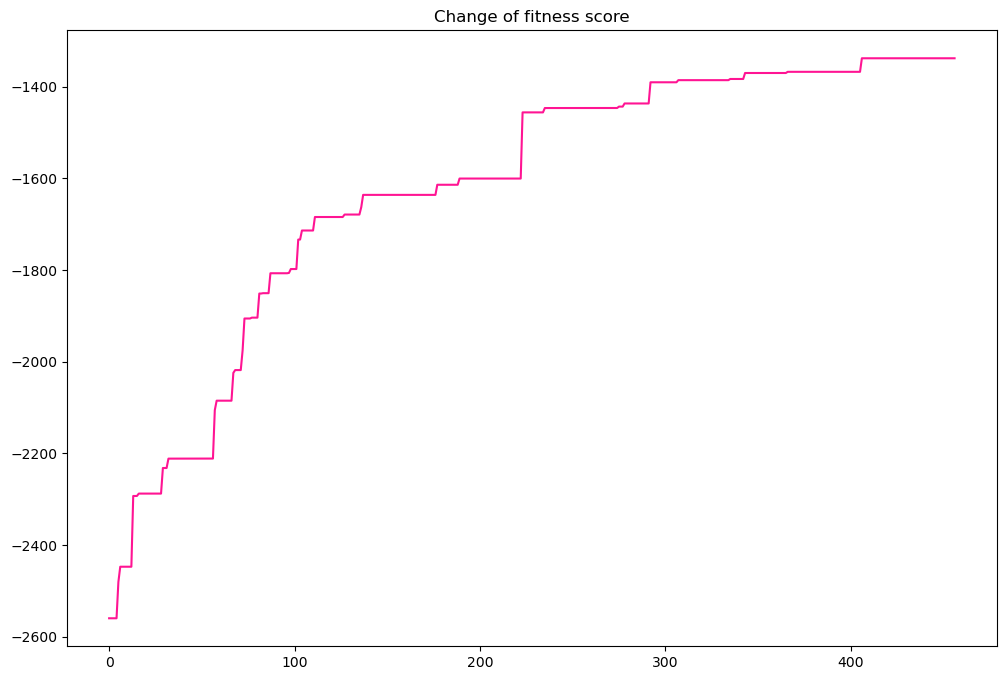

In [159]:
plt.figure(figsize = (12,8))
plt.plot(fitness_change, color='deeppink')
plt.title('Change of fitness score')
plt.show()

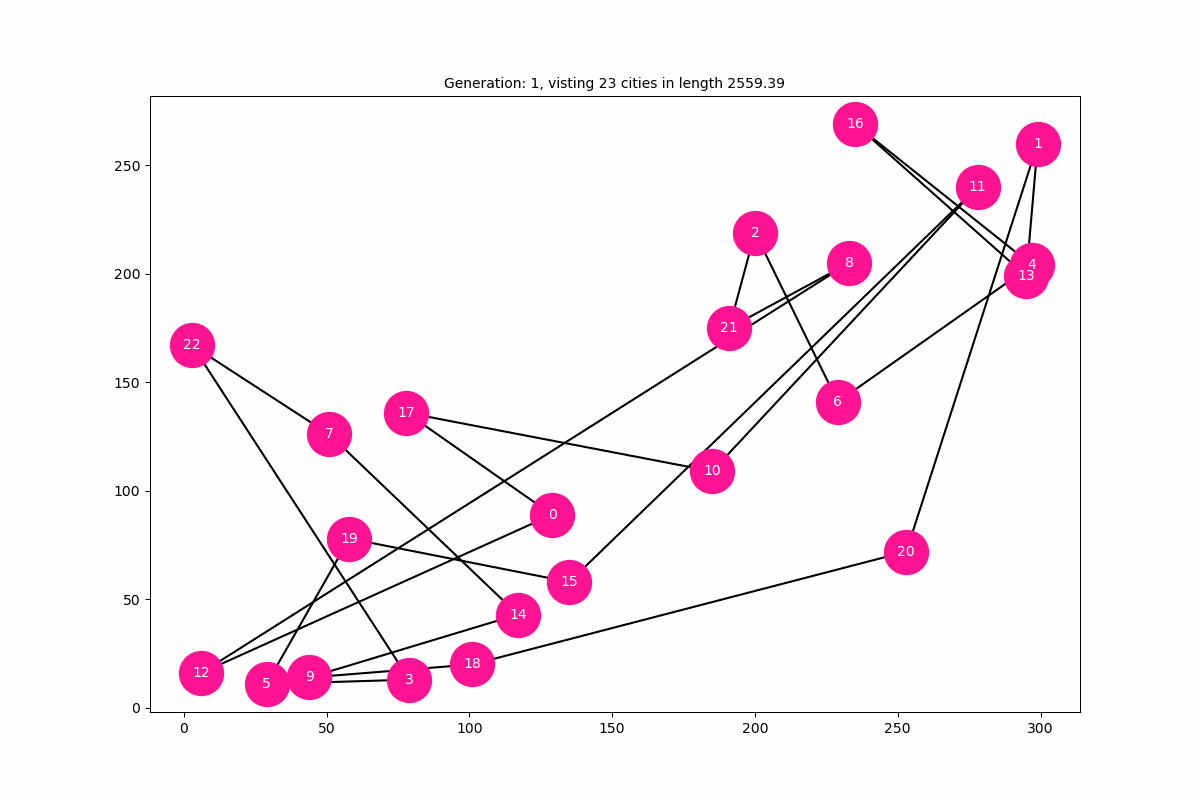

In [160]:
with imageio.get_writer('ga_learning.gif', mode = 'I') as writer:
    for generation in range(1, len(fitness_change)):
        image = imageio.imread(f'{generation}.png')
        writer.append_data(image)

Image('ga_learning.gif')

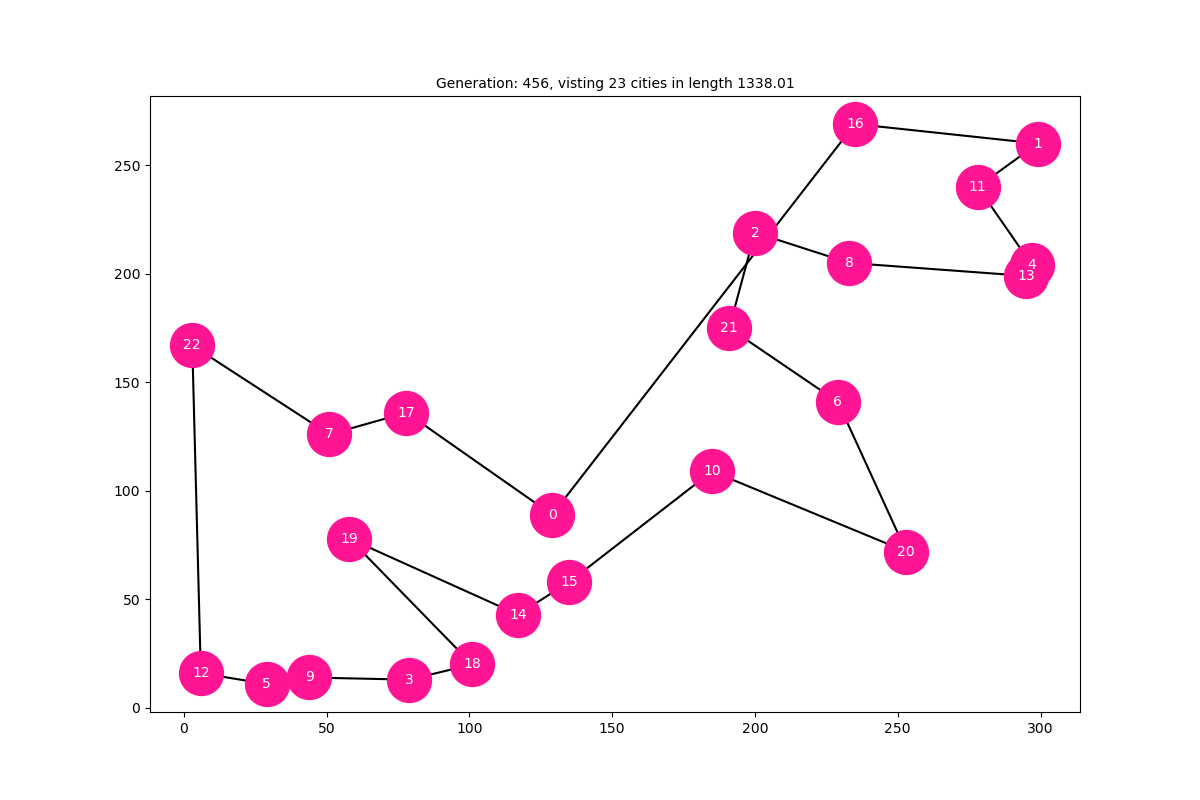

In [161]:
Image(open(f'{len(fitness_change)-1}.png', 'rb').read())

In [162]:
plt.close('all')

for filename in os.listdir('.'):
    if filename.endswith('.png'):
        os.remove(filename)